Trial 10 Complete [00h 10m 08s]
val_loss: 0.0008980004349723458

Best val_loss So Far: 0.0007061964715830982
Total elapsed time: 00h 58m 20s
Epoch 1/100
1939/1939 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0080 - mae: 0.0766 - val_loss: 0.0011 - val_mae: 0.0271 - learning_rate: 1.0000e-05
Epoch 2/100
1939/1939 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0023 - mae: 0.0381 - val_loss: 8.9941e-04 - val_mae: 0.0255 - learning_rate: 1.0000e-05
Epoch 3/100
1939/1939 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0014 - mae: 0.0308 - val_loss: 8.5443e-04 - val_mae: 0.0238 - learning_rate: 1.0000e-05
Epoch 4/100
1939/1939 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0011 - mae: 0.0272 - val_loss: 8.3140e-04 - val_mae: 0.0231 - learning_rate: 1.0000e-05
Epoch 5/100
1939/1939 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 9.5466e-04 - mae: 0.0258 - val_loss: 7.8956e-04 - val_mae: 0.0226 - learning_rate: 1.0000e-05
Epoch 6/100
1939/1939 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 9.0645e-04 - mae: 0.0250 - val

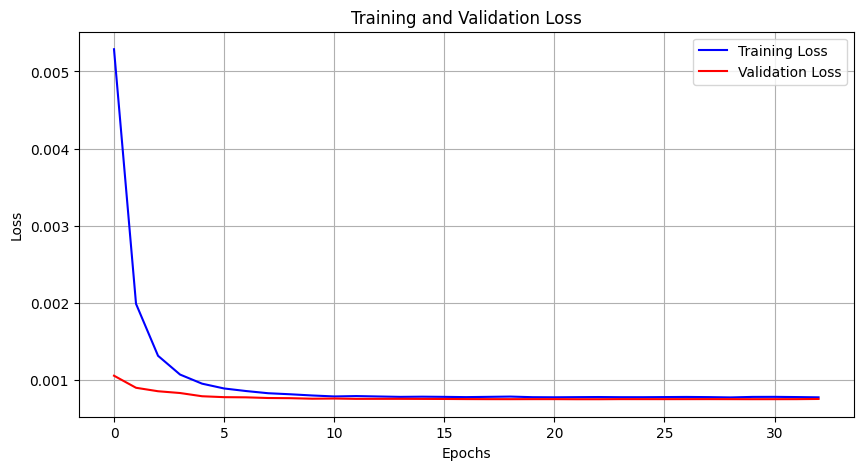

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import keras_tuner as kt
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv(r"C:\Users\acer\Dropbox\PC\Desktop\minor project\Dataset.csv")

# Feature Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = scaler_X.fit_transform(df[['Calories']])
y = scaler_y.fit_transform(df[['FatContent', 'SaturatedFatContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent']])

# Reshape for LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning function
def build_model(hp):
    model = Sequential()
    
    lstm_layers = hp.Int('lstm_layers', min_value=1, max_value=3)
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    
    model.add(LSTM(units=lstm_units, activation='relu', return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    for _ in range(lstm_layers - 1):
        model.add(LSTM(units=lstm_units, activation='relu', return_sequences=True))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    model.add(LSTM(units=lstm_units, activation='relu', return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(y.shape[1], activation='linear'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[5e-5, 1e-5])),
                  loss='log_cosh',
                  metrics=['mae'])
    return model

# Hyperparameter tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='hyper_tuning',
    project_name='lstm_tuning'
)

tuner.search(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

# Get best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Apply gradient clipping
optimizer = tf.keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate'), clipnorm=1.0)
best_model.compile(optimizer=optimizer, loss='log_cosh', metrics=['mae'])

# Train best model
history = best_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate best model
loss, mae = best_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test MAE: {mae}')

# Predictions
y_pred = best_model.predict(X_test)

# Calculate Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


In [10]:
import pandas as pd

df = pd.read_csv(r"C:\Users\acer\Dropbox\PC\Desktop\minor project\Dataset_Categorized_With_Prediction (1).csv")

# Function to recommend food items based on calorie input and meal type
def recommend_diet_by_calories(required_calories, tolerance=50, num_suggestions=5, diet_preference="all"):
    lower_bound = required_calories - tolerance
    upper_bound = required_calories + tolerance
    
    # Filter based on diet preference
    if diet_preference == "vegetarian":
        filtered_recipes = df[(df["Calories"] >= lower_bound) & (df["Calories"] <= upper_bound) & (df["DietType"] == "Vegetarian")]
    elif diet_preference == "non-vegetarian":
        filtered_recipes = df[(df["Calories"] >= lower_bound) & (df["Calories"] <= upper_bound) & (df["DietType"] == "Non-Vegetarian")]
    else:
        filtered_recipes = df[(df["Calories"] >= lower_bound) & (df["Calories"] <= upper_bound)]
    
    if filtered_recipes.empty:
        return ["No recipe found within the calorie range and diet preference."]
    
    num_suggestions = min(num_suggestions, len(filtered_recipes))
    random_recipes = filtered_recipes.sample(n=num_suggestions)
    recommendations = []
    for _, random_recipe in random_recipes.iterrows():
        recipe_name = random_recipe["Name"]
        recipe_image = random_recipe["Images"]
        recipe_ingredients = random_recipe["RecipeIngredientParts"]
        recipe_instructions = random_recipe["RecipeInstructions"]
        
        # Nutritional values
        calories = random_recipe["Calories"]
        fat = random_recipe["FatContent"]
        saturated_fat = random_recipe["SaturatedFatContent"]
        cholesterol = random_recipe["CholesterolContent"]
        sodium = random_recipe["SodiumContent"]
        carbs = random_recipe["CarbohydrateContent"]
        fiber = random_recipe["FiberContent"]
        sugar = random_recipe["SugarContent"]
        protein = random_recipe["ProteinContent"]
        
        recommendations.append({
            "name": recipe_name,
            "images": recipe_image,
            "calories": calories,
            "ingredients": recipe_ingredients,
            "instructions": recipe_instructions,
            "fat": fat,
            "saturated_fat":saturated_fat,
            "carbs": carbs,
            "fiber": fiber,
            "sugar": sugar,
            "protein": protein,
            "cholesterol": cholesterol,
            "sodium": sodium
        })
    
    return recommendations

# Function to generate diet plan with multiple meal suggestions
def generate_diet_plan(daily_calories, num_meals, meal_distribution, diet_preference="all"):
    diet_plan = {}
    meal_names = ["Breakfast", "Lunch", "Dinner"]
    if len(meal_distribution) != num_meals:
        raise ValueError("Meal distribution length must match the number of meals.")

    meal_calories = [(daily_calories * percentage) // 100 for percentage in meal_distribution]
    
    for meal_name, calories in zip(meal_names, meal_calories):
        recommendations = recommend_diet_by_calories(calories, tolerance=50, num_suggestions=5, diet_preference=diet_preference)
        diet_plan[meal_name] = recommendations
    
    return diet_plan

# Example usage
while True:
    try:
        daily_calories = int(input("Enter your total daily calories: "))
        if daily_calories <= 0:
            raise ValueError("Calories must be a positive integer.")
        break
    except ValueError as e:
        print(f"Invalid input: {e}. Please enter a valid number for calories.")

# Ask the user for diet preference
diet_preference = input("Enter your diet preference (vegetarian/non-vegetarian): ").strip().lower()
if diet_preference not in ["vegetarian", "non-vegetarian"]:
    print("Invalid input. Defaulting to 'all' diet preference.")
    diet_preference = "all"

num_meals = 3
meal_distribution = [30, 40, 30]

diet_plan = generate_diet_plan(daily_calories, num_meals, meal_distribution, diet_preference)

# Display the Diet Plan with complete nutritional breakdown
print("\nGenerated Diet Plan:")
for meal, recommendations in diet_plan.items():
    print(f"\n{meal}:")
    for recommendation in recommendations:
        if isinstance(recommendation, dict):
            print(f'Food Name: {recommendation["name"]}')
            print(f'Calories: {recommendation["calories"]}')
            print(f'Protein: {recommendation["protein"]}g')
            print(f'Fat: {recommendation["fat"]}g')
            print(f'Carbohydrate: {recommendation["carbs"]}g')
            print(f'Saturated Fat: {recommendation["saturated_fat"]}g')
            print(f'Cholesterol: {recommendation["cholesterol"]}mg')
            print(f'Fiber: {recommendation["fiber"]}g')
            print(f'Sugar: {recommendation["sugar"]}g')
            print(f'Sodium: {recommendation["sodium"]}mg')
            print(f'Image Link: {recommendation["images"]}')
            print(f'Recipe Instructions: {recommendation["instructions"]}')
            print(f'Recipe Ingredients: {recommendation["ingredients"]}\n')
        else:
            print(recommendation)



Generated Diet Plan:

Breakfast:
Food Name: Sweet Onion Bake
Calories: 554.5
Protein: 21.9g
Fat: 43.5g
Carbohydrate: 20.2g
Saturated Fat: 26.3g
Cholesterol: 0.2261mg
Fiber: 1.4g
Sugar: 4.6g
Sodium: 0.9657mg
Image Link: https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/16/72/45/picu7VUyE.jpg
Recipe Instructions: Melt 4 T.
butter in a skillet.
Add the onions and saute' for about 20 minutes, or until golden brown.
Place half of the onions in a 8X8 Baking dish that has been sprayed with cooking spray.
Sprinkle with half of the cheese and 1/4 cup cracker crumbs.
Top with remaining onions and cheese.
Whisk eggs and next three ingredients and pour over onion mixture.
Melt remaining 2 T.
butter and add the remaining 1/2 cup cracker crumbs.
Cook over medium heat, stirring often, until crumbs are lightly browned.
Sprinkle crumbs evenly over the onion mixture and bake in a preheated 350 degree oven for about 20 minutes, or until lightly browned and set

In [4]:
# Get the best hyperparameters and print them
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hps.values)


Best Hyperparameters: {'lstm_layers': 1, 'lstm_units': 96, 'dropout_rate': 0.2, 'learning_rate': 1e-05}
